In [16]:
import os
from pathlib import Path

import geopandas as gpd
import matplotlib.pyplot as plt
import pandana as pdna
import pandas as pd

from nad.accessibility import create_network, get_accessibility_metrics
from nad.load import (
    get_census_level,
    load_ageb_geometry,
    load_all_equipments,
    load_block_geometry,
    load_census,
)

In [3]:
data_path = Path(os.environ["DATA_PATH"])
geostatistical_framework_path = Path(os.environ["GEOSTATISTICAL_FRAMEWORK_PATH"])
population_grids_path = Path(os.environ["POPULATION_GRIDS_PATH"])
census_path = Path(os.environ["CENSUS_PATH"])

cache_path = Path("./cache")
results_path = Path("./results")

# Constants

In [4]:
ADJUSTMENT_FACTOR = 3
WALK_SPEED = 5  # km/h
MAX_DISTANCE = 10_000  # aprox 2 hour of walking
NUM_POIS = 5

EQUIPAMIENTOS = {
    # "guarderia": {"radius": 750},
    # "preescolar": {"radius": 750},
    # "primaria": {"radius": 500},
    # "secundaria": {"radius": 1_000},
    # "preparatoria": {"radius": 5_000},
    # "universidad": {"radius": 50_000},
    "parque": {"radius": 670},
    "auditorio": {"radius": 1_000},
    "biblioteca": {"radius": 10_000},
    "cine": {"radius": 1_500},
    "unidad_deportiva": {"radius": 10_000},
    "hospital": {"radius": 50_000},
    "centro_salud": {"radius": 1_000},
}

# Datos

## Equipamientos

In [5]:
df_equip = (
    load_all_equipments(data_path)
    .assign(
        capacity=1,
        geometry=lambda df: df["geometry"].centroid,
    )
    .query(
        "~equipamiento.isin(['guarderia', 'preescolar', 'primaria', 'secundaria', 'preparatoria', 'universidad'])",
    )
)

## AGEBs

In [6]:
df_geom_agebs = load_ageb_geometry(
    population_grids_path / "final" / "zone_agebs" / "shaped" / "2020" / "08.2.03.gpkg",
)

## Manzanas

In [7]:
df_census_base = load_census(census_path / "2020" / "08.csv")
df_census_blocks = get_census_level(df_census_base, level="block")

df_geom_blocks = load_block_geometry(
    geostatistical_framework_path / "2020" / "08_chihuahua" / "08m.shp",
    ageb_cvegeos=df_geom_agebs.index,
)

df_blocks = df_geom_blocks.join(df_census_blocks, how="inner").filter(
    ["POBTOT", "TVIVPARHAB", "CVEGEO_AGEB", "geometry"],
)

# Stats

In [8]:
net_path = cache_path / f"network_{hash(MAX_DISTANCE)}.h5"

if not net_path.exists():
    gdf_vialidades = gpd.read_file(
        data_path / "datos/Vialidad/VialidadWgs84.shp",
    ).to_crs(
        "EPSG:6372",
    )
    net = create_network(gdf_vialidades, net_path, MAX_DISTANCE)
else:
    net = pdna.Network.from_hdf5(net_path)

Generating contraction hierarchies with 1 threads.
Setting CH node vector of size 59222
Setting CH edge vector of size 82175
Range graph removed 174 edges of 164350
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


In [9]:
coords = df_blocks.centroid.get_coordinates()
df_blocks_accessibility = (
    df_blocks.assign(origin_id=net.get_node_ids(coords["x"], coords["y"]))
    .reset_index()
    .set_index("origin_id")
)

In [10]:
scores = pd.DataFrame()
for nombre, item in EQUIPAMIENTOS.items():
    df_temp = df_equip[df_equip["equipamiento"] == nombre].assign(capacity=1)
    accessibility_scores = get_accessibility_metrics(
        net,
        df_temp,
        df_blocks_accessibility["POBTOT"],
        nombre,
        MAX_DISTANCE,
        NUM_POIS,
        WALK_SPEED,
        item["radius"],
        ADJUSTMENT_FACTOR,
    )
    accessibility_scores["category"] = nombre
    scores = pd.concat([scores, accessibility_scores])

In [11]:
final_score = scores.groupby("origin_id").agg({"accessibility_score": "sum"})
results = df_blocks_accessibility.join(final_score)

df_blocks_accessibility = df_blocks_accessibility.assign(
    accessibility_score=results["accessibility_score"],
)

Q3 = df_blocks_accessibility["accessibility_score"].quantile(0.9)
upper_bound = Q3 + 1.5 * Q3

df_blocks_accessibility["accessibility_score"] = df_blocks_accessibility[
    "accessibility_score"
].clip(
    0,
    upper_bound,
)
df_blocks_accessibility["accessibility_score"] = (
    df_blocks_accessibility["accessibility_score"]
    - df_blocks_accessibility["accessibility_score"].min()
) / (
    df_blocks_accessibility["accessibility_score"].max()
    - df_blocks_accessibility["accessibility_score"].min()
)

df_blocks_accessibility = df_blocks_accessibility.reset_index().set_index("CVEGEO")

In [12]:
temp = df_blocks_accessibility.join(scores[["time", "category"]], on="origin_id")

parque = temp.query("category == 'parque'")

manzanas_clinica_hospital = (
    temp[temp["category"].isin(["centro_salud", "hospital"])]
    .groupby("CVEGEO")
    .agg({"time": "min", "TVIVPARHAB": "first"})
)

preparatoria = temp.query("category == 'preparatoria'")

df_blocks_accessibility = df_blocks_accessibility.assign(
    tiempo_parque=parque["time"],
    tiempo_clinica_hospital=manzanas_clinica_hospital["time"],
    tiempo_preparatoria=preparatoria["time"],
    hogares_parque_15mi=parque[parque["time"] <= 15]["TVIVPARHAB"].fillna(0),
    hogares_clinica_hospital_30mi=manzanas_clinica_hospital[
        manzanas_clinica_hospital["time"] <= 30
    ]["TVIVPARHAB"].fillna(0),
    hogares_preparatoria_30mi=preparatoria[preparatoria["time"] <= 30][
        "TVIVPARHAB"
    ].fillna(0),
)

df_blocks_accessibility.to_file(results_path / "accessibility_blocks.gpkg")

array([[<Axes: title={'center': 'accessibility_score'}>]], dtype=object)

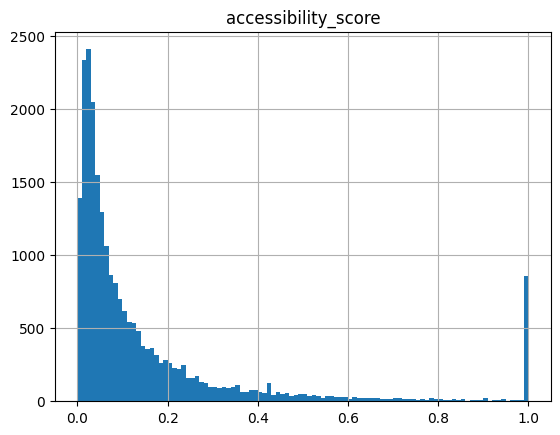

In [13]:
df_blocks_accessibility.hist(column="accessibility_score", bins=100, range=(0, 1))

(2060776.2185449984, 2094200.6217550028, 2166377.112450001, 2198901.89155)

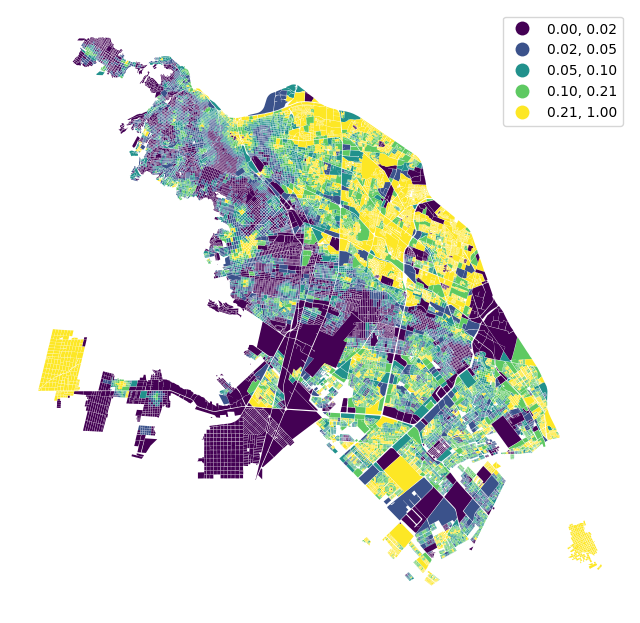

In [17]:
fig, ax = plt.subplots(figsize=(8, 8))
df_blocks_accessibility.plot(
    column="accessibility_score", scheme="quantiles", k=5, legend=True, ax=ax,
)
ax.axis("off")